In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [2]:
db= mysql.connector.connect(host= 'localhost',
                   username= 'root',
                   password= '123#Priyam#123',
                   database= 'ecommerce')
cur= db.cursor()

## 1. Calculate the number of orders per month in 2018.

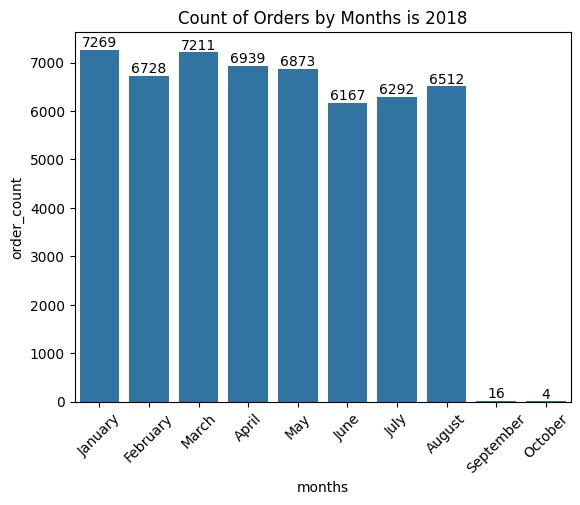

In [82]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
            from orders where year(order_purchase_timestamp) = 2018
            group by months """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

## 2. Find the average number of products per order, grouped by customer city.

In [53]:
query= """ with count_per_order as
            (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
            from orders 
            join order_items on
            orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id) 
            
            select customers.customer_city, round(avg(count_per_order.order_count), 2)
            from customers
            join count_per_order on
            customers.customer_id = count_per_order.customer_id
            group by customers.customer_city """
cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns= ['City', 'Avg. products/orders'])
df

,City,Avg. products/orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


## 3. Calculate the percentage of total revenue contributed by each product category.


In [62]:
query= """ select upper(products.product_category) as category,
            round(sum(payments.payment_value) / (select sum(payments.payment_value) from payments)*100, 2) as sales_percentage
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category 
            order by sales_percentage desc """
cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns= ['Category', 'Percentage(%)'])
df

,Category,Percentage(%)
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


## 4. Identify the correlation between product price and the number of times a product has been purchased.

In [76]:
query= """ select products.product_category, 
            count(order_items.product_id),
            round(avg(order_items.price),2)
            from products join order_items
            on products.product_id = order_items.product_id
            group by products.product_category """

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1= df["order_count"]
arr2= df["price"]

a= np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


## 5. Calculate the total revenue generated by each seller, and rank them by revenue.

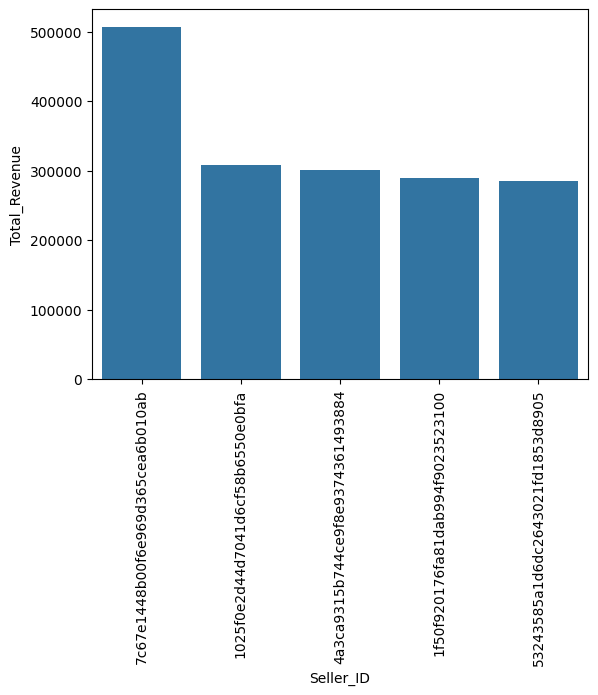

In [99]:
query= """ select *, dense_rank() over(order by revenue desc) as rn
            from
                (select order_items.seller_id, sum(payments.payment_value) revenue
                from order_items join payments
                on order_items.order_id = payments.order_id
                group by order_items.seller_id) as a"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns= ['Seller_ID', 'Total_Revenue', 'Rank'])
df.head(5)

sns.barplot(x= "Seller_ID", y= "Total_Revenue", data= df.head(5))
plt.xticks(rotation= 90)
plt.show()